In [1]:
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import obspy
import os
import math 

In [2]:
%matplotlib inline

def ler_cabecalhos_su(infile):
    try:
        stream = obspy.read(infile, format='SU', headonly=True)
        if not stream:
            print(f"Arquivo '{infile}' está vazio ou não pôde ser lido.")
            return

        print(f"--- Mostrando Cabeçalhos SU do 1º traço de '{infile}' ---")
        
        if 'su' in stream[0].stats and hasattr(stream[0].stats.su, 'trace_header'):
            print("Valores não-nulos encontrados:")
            valores_encontrados = False
            for chave, valor in stream[0].stats.su.trace_header.items():
                if valor != 0: 
                    print(f"  {chave}: {valor}")
                    valores_encontrados = True
            if not valores_encontrados:
                print("  Nenhum valor de cabeçalho (não-nulo) encontrado.")
        else:
            print("Não foram encontrados cabeçalhos específicos do SU (tr.stats.su.trace_header).")

    except Exception as e:
        print(f"ERRO ao tentar ler o arquivo SU '{infile}' com Obspy: {e}")

def calcular_geometria_convencional_em_memoria(infile, n_geo, offset_min, delta_geo, delta_tiro, x_s1):
    print("--- Método Alternativo: Calculando geometria CONVENCIONAL em memória ---")
    try:
        stream_info = obspy.read(infile, format='SU', headonly=True)
        total_tracos = len(stream_info)
        print(f"Arquivo de entrada '{infile}' tem {total_tracos} traços.")
    except Exception as e:
        print(f"ERRO ao ler o arquivo de entrada '{infile}': {e}")
        return pd.DataFrame(columns=['ep', 'cdp'])

    delta_cdp_coord = delta_geo / 2
    x_cdp1_coord = (x_s1 + (x_s1 + offset_min)) / 2
    
    lista_de_tracos = []
    print("Calculando pares (ep, cdp) para cada traço...")

    for i in range(total_tracos):
        i_tiro = i // n_geo
        i_geo = i % n_geo
        
        ep_val = i_tiro + 1
        sx_val = x_s1 + (i_tiro * delta_tiro)
        offset_val = offset_min + (i_geo * delta_geo)
        gx_val = sx_val + offset_val
        cdp_coord = (sx_val + gx_val) / 2
        
        cdp_num = 1 + math.floor((cdp_coord - x_cdp1_coord) / delta_cdp_coord)
        
        lista_de_tracos.append([ep_val, cdp_num])

    df = pd.DataFrame(lista_de_tracos, columns=['ep', 'cdp'])
    print("DataFrame criado com sucesso.")
    return df

def plotar_carta_de_empilhamento(df_geometria, alpha_val, label1='ep', label2='cdp'):
    if df_geometria.empty:
        print("Não há dados para plotar.")
        return

    print(f"Plotando carta de empilhamento com alpha={alpha_val}...")
    plt.figure(figsize=(12, 8))
    
    plt.scatter(df_geometria[label2], df_geometria[label1], s=5, marker='.', alpha=alpha_val)
    
    plt.xlabel(label2)
    plt.ylabel(label1)
    plt.title(f'Carta de Empilhamento (Densidade de Multiplicidade): {label1} vs {label2}')
    plt.gca().invert_yaxis()
    plt.grid(True, linestyle='--', alpha=alpha_val)
    plt.show()

def calcular_geometria_base_fixa_em_memoria(infile, params_parte_2):    
    print("ERRO: Função 'calcular_geometria_base_fixa_em_memoria' ainda não implementada.")
    
    return pd.DataFrame(columns=['ep', 'cdp'])

def calcular_geometria_base_fixa_em_memoria(infile, params):

    N = params['N']
    dx_g = params['dx_g']
    dx_s = params['dx_s']
    offset_min = params['offset_min']
    T = params['tiros_por_base']
    num_bases = params['bases_total']
    
    delta_cdp_coord = dx_s / 2
    
    x_cdp1_base1_coord = (params['x_s_base_1'] + (params['x_s_base_1'] + offset_min)) / 2
    
    lista_de_tracos = []
    traco_global_id = 0

    print(f"Calculando {num_bases} bases com {T} tiros cada...")

    for i_base in range(num_bases):
        
        deslocamento_base = i_base * T * dx_g
        X_G1_base = offset_min + deslocamento_base
        
        tiro_global_inicial = i_base * T + 1
        X_S_base_inicial = i_base * T * dx_s
        
        for i_tiro_local in range(T):
            
            ep_val = tiro_global_inicial + i_tiro_local
            
            sx_val = X_S_base_inicial + (i_tiro_local * dx_s)
            
            for i_geo_local in range(N):
                
                traco_global_id += 1
                
                gx_val = X_G1_base + (i_geo_local * dx_g)
                
                offset_val = gx_val - sx_val
                
                cdp_coord = (sx_val + gx_val) / 2
                
                cdp_num = 1 + math.floor((cdp_coord - x_cdp1_base1_coord) / delta_cdp_coord + 0.5)
                
                lista_de_tracos.append([ep_val, sx_val, gx_val, offset_val, cdp_num])

    colunas = ['ep', 'sx', 'gx', 'offset', 'cdp']
    df = pd.DataFrame(lista_de_tracos, columns=colunas)
    print(f"Geometria base fixa calculada para {traco_global_id} traços.")
    print("DataFrame criado com sucesso.")
    return df

# Parte I

## Parâmetros gerais para as questões I.1, I.2, I.3 e I.4

In [3]:
%matplotlib inline


offset_min_1 = 10.0
delta_geo_1 = 10.0
delta_tiro_1 = 20.0
x_s1_1 = 0.0
n_geo_1 = 96
multiplicidade_max_1 = 24

caminho_base = '~/projetos/sismica-reflexao/avaliacao-1/arquivos-null/'
caminho_corrigido = os.path.expanduser(caminho_base)

infile_1 = os.path.join(caminho_corrigido, 'null.su')
outfile_1 = os.path.join(caminho_corrigido, 'null-geometria.su')

infile_2 = os.path.join(caminho_corrigido, 'null2.su')
outfile_2 = os.path.join(caminho_corrigido, 'null2-geometria.su')

## Questão I.2.1

In [4]:
ler_cabecalhos_su(infile_1)

--- Mostrando Cabeçalhos SU do 1º traço de '/home/gabriel/projetos/sismica-reflexao/avaliacao-1/arquivos-null/null.su' ---
Valores não-nulos encontrados:
  unpacked_header: b'\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x03\xe9\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x02\xee\x0f\xa0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\

## Questão I.3

In [5]:
n = n_geo_1  
print(f"Valor para n= (número de geofones): {n}")
try:
    stream_info = obspy.read(infile_1, format='SU', headonly=True)
    total_tracos = len(stream_info)
    nplot = total_tracos // n
    print(f"Valor para nplot= (número de pontos de tiro): {nplot}")
except Exception as e:
    print(f"Não foi possível calcular o nplot. Erro: {e}")
    nplot = 0 


Valor para n= (número de geofones): 96
Valor para nplot= (número de pontos de tiro): 500


## Questão I.3

--- Método Alternativo: Calculando geometria CONVENCIONAL em memória ---
Arquivo de entrada '/home/gabriel/projetos/sismica-reflexao/avaliacao-1/arquivos-null/null.su' tem 48000 traços.
Calculando pares (ep, cdp) para cada traço...
DataFrame criado com sucesso.
Plotando carta de empilhamento com alpha=0.6...


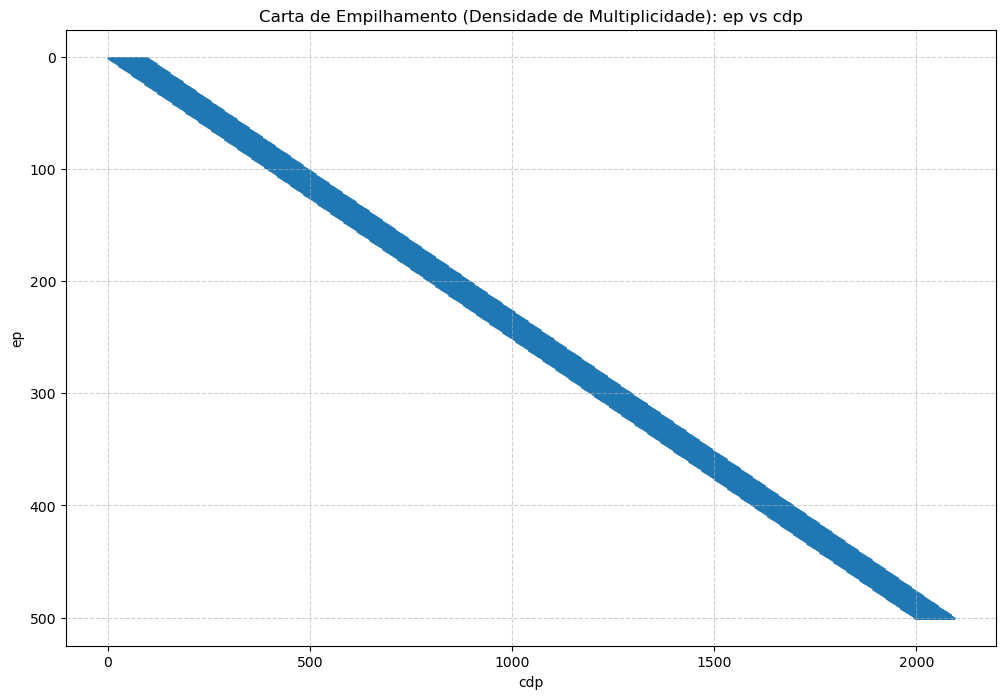

In [6]:
df_geometria_1 = calcular_geometria_convencional_em_memoria(
    infile = infile_1,
    n_geo = n_geo_1,
    offset_min = offset_min_1,
    delta_geo = delta_geo_1,
    delta_tiro = delta_tiro_1,
    x_s1 = x_s1_1
)

plotar_carta_de_empilhamento(
    df_geometria_1,
     alpha_val = 0.6,
    label1 = 'ep', 
    label2 = 'cdp',
   
)

# Parte II

## Parâmetros para questões

In [7]:
print("--- EXECUÇÃO: Definindo parâmetros da Base Fixa ---")

multiplicidade_max_2 = 24
offset_min_2 = 30.0
delta_geo_2 = 1.0
delta_tiro_2 = 1.0
x_s1_2 = 0.0
n_geo_2 = 48
tiros_por_base = 24

params_parte_2 = {
    'M': multiplicidade_max_2,
    'N': n_geo_2,
    'dx_g': delta_geo_2,
    'dx_s': delta_tiro_2,
    'offset_min': offset_min_2,
    'x_s_base_1': x_s1_2,
    'tiros_por_base': tiros_por_base,
    'bases_total': 2,
}

print(f"Parâmetros definidos: {params_parte_2}")


--- EXECUÇÃO: Definindo parâmetros da Base Fixa ---
Parâmetros definidos: {'M': 24, 'N': 48, 'dx_g': 1.0, 'dx_s': 1.0, 'offset_min': 30.0, 'x_s_base_1': 0.0, 'tiros_por_base': 24, 'bases_total': 2}


## Preparação para questões

In [8]:
calcular_geometria_base_fixa_em_memoria.__globals__.update({
    'calcular_geometria_base_fixa_em_memoria': calcular_geometria_base_fixa_em_memoria
})


## Questões II.2 e II.3

Calculando 2 bases com 24 tiros cada...
Geometria base fixa calculada para 2304 traços.
DataFrame criado com sucesso.
Plotando carta de empilhamento com alpha=1.0...


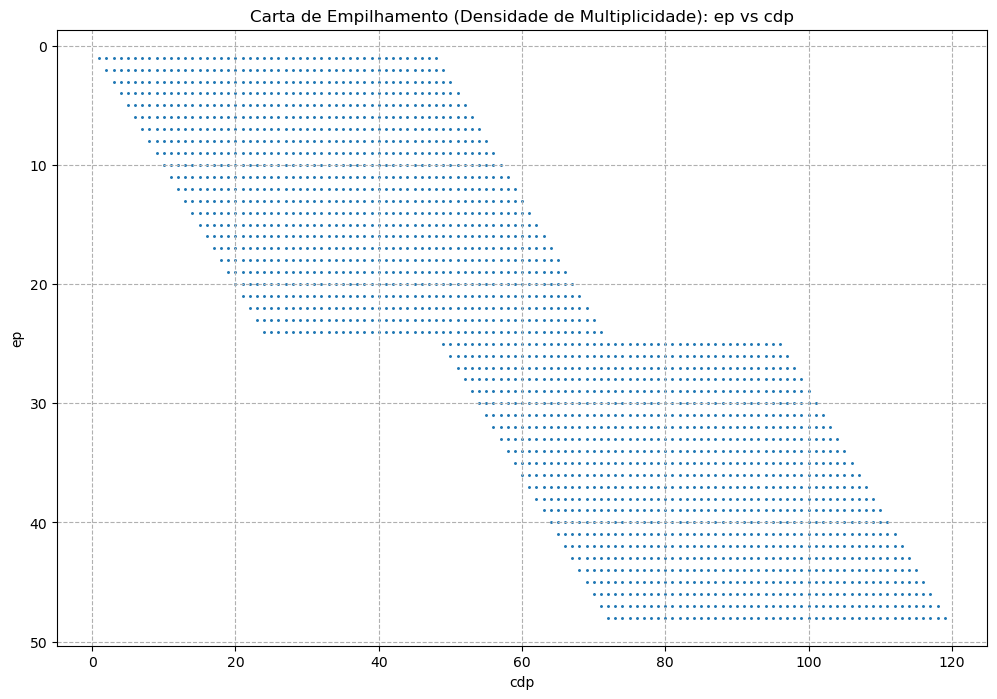

In [9]:

df_geometria_2 = calcular_geometria_base_fixa_em_memoria(
    infile = infile_2,
    params = params_parte_2
)

plotar_carta_de_empilhamento(
    df_geometria_2,
    alpha_val = 1.0,
    label1 = 'ep', 
    label2 = 'cdp'
)
